In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
df = pd.read_csv("/kaggle/input/final-dataset/finalized_extreme.csv")
df

,sentence_ID,words,labels,labels_encoded2
0,0,Data,B-PARAMETER PROPN,15
1,0,Recorder,B-COMPONENT NOUN,4
2,0,File,O NOUN,35
3,0,Index,O NOUN,35
4,0,is,O AUX,33
...,...,...,...,...
58974,4976,obstacles,B-COMPONENT NOUN,4
58975,4976,.,O PUNCT,40
58976,4976,Fly,B-ACTION VERB,2
58977,4976,with,O ADP,31


In [3]:
df["words"] = df["words"].str.lower()

In [4]:
df.columns

Index(['sentence_ID', 'words', 'labels', 'labels_encoded2'], dtype='object')

In [5]:
df.head()

,sentence_ID,words,labels,labels_encoded2
0,0,data,B-PARAMETER PROPN,15
1,0,recorder,B-COMPONENT NOUN,4
2,0,file,O NOUN,35
3,0,index,O NOUN,35
4,0,is,O AUX,33


In [6]:
df["labels_encoded2"].unique()

array([15,  4, 35, 33, 43, 40, 42, 32, 30, 31, 36, 14,  2, 41, 38, 18,  8,
       12, 37,  3, 23,  7,  0, 34, 10, 28, 39, 21, 19,  1, 16, 29, 27, 11,
       13,  6,  9, 24, 17,  5, 25, 20, 22, 26])

In [7]:
# !pip install wandb
import wandb
wandb.login(key = "1d4c63cc7a44c2478cf37ccdf5c0661bdaa89c2c")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
df["labels_encoded2"].nunique()

44

In [9]:
df["labels_encoded2"].nunique()

44

In [10]:
df["labels"].unique()

array(['B-PARAMETER PROPN', 'B-COMPONENT NOUN', 'O NOUN', 'O AUX', 'O X',
       'O PUNCT', 'O VERB', 'O ADV', 'O ADJ', 'O ADP', 'O NUM',
       'B-PARAMETER NOUN', 'B-ACTION VERB', 'O SCONJ', 'O PRON',
       'B-STATE NOUN', 'B-FUNCTION VERB', 'B-ISSUE VERB', 'O PART',
       'B-COMPONENT ADJ', 'I-ACTION VERB', 'B-FUNCTION NOUN',
       'B-ACTION NOUN', 'O INTJ', 'B-ISSUE NOUN', 'I-STATE VERB',
       'O PROPN', 'I-ACTION ADP', 'B-STATE PROPN', 'B-ACTION PROPN',
       'B-STATE ADJ', 'O', 'I-STATE NOUN', 'B-ISSUE PROPN',
       'B-PARAMETER ADJ', 'B-FUNCTION ADJ', 'B-ISSUE ADJ',
       'I-COMPONENT NOUN', 'B-STATE ADV', 'B-COMPONENT VERB',
       'I-FUNCTION VERB', 'B-STATE VERB', 'I-ACTION NOUN',
       'I-PARAMETER NOUN'], dtype=object)

In [11]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DebertaTokenizer, DebertaForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
import numpy as np
import pandas as pd

class RobertaModel:
    def __init__(self):
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

    def dataset_setting(self, dataset_text_att, dataset_label_att):
        text = dataset_text_att.tolist()
        labels = dataset_label_att.tolist()
        data = {"text": text, "labels": labels}
        dataset = Dataset.from_dict(data)
        dataset = dataset.train_test_split(test_size=0.33, seed = 1)
        return dataset

    def tokenize_function(self, examples):
        return self.tokenizer(examples['text'], padding='max_length', truncation=True)

    def mapping(self, dataset):
        tokenized_dataset = dataset.map(self.tokenize_function, batched=True)
        return tokenized_dataset

    def setting_format(self, columns, tokenized_dataset):
        tokenized_dataset.set_format(type='torch', columns=columns)
        return tokenized_dataset

    def init_model(self, num_labels=2):
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=num_labels)
        return model

    def training_args(self, output_dir, evaluation_strategy, learning_rate,
                      per_device_train_batch_size, per_device_eval_batch_size,
                      num_train_epochs, weight_decay):
        training_args = TrainingArguments(
            output_dir=output_dir,
            evaluation_strategy=evaluation_strategy,
            learning_rate=learning_rate,
            per_device_train_batch_size=per_device_train_batch_size,
            per_device_eval_batch_size=per_device_eval_batch_size,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            save_steps = 0,
            save_strategy = "epoch"
        )
        return training_args

    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=1)
        accuracy = accuracy_score(labels, predictions)
        precision = precision_score(labels, predictions, average='weighted')
        recall = recall_score(labels, predictions, average='weighted')
        f1 = f1_score(labels, predictions, average='weighted')
        return {"accuracy": accuracy,"precision": precision, "recall": recall, "f1": f1}

    def trainer_setup(self, model, training_args, train_dataset, eval_dataset):
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            tokenizer=self.tokenizer,
            compute_metrics=self.compute_metrics
        )
        return trainer

    def train(self, trainer):
        print("Training has been initiated")
        trainer.train()
        print("Training Completed")

    def result(self, trainer):
        print(trainer.evaluate())

    def classification_report(self, trainer, eval_dataset):
        # Make predictions
        predictions = trainer.predict(eval_dataset)
        logits, labels = predictions.predictions, predictions.label_ids

        # Get the predicted classes
        preds = np.argmax(logits, axis=1)

        # Generate the classification report
        report = classification_report(labels, preds, target_names=['B-PARAMETER PROPN', 'B-COMPONENT NOUN', 'O NOUN', 'O AUX', 'O X',
       'O PUNCT', 'O VERB', 'O ADV', 'O ADJ', 'O ADP', 'O NUM',
       'B-PARAMETER NOUN', 'B-ACTION VERB', 'O SCONJ', 'O PRON',
       'B-STATE NOUN', 'B-FUNCTION VERB', 'B-ISSUE VERB', 'O PART',
       'B-COMPONENT ADJ', 'I-ACTION VERB', 'B-FUNCTION NOUN',
       'B-ACTION NOUN', 'O INTJ', 'B-ISSUE NOUN', 'I-STATE VERB',
       'O PROPN', 'I-ACTION ADP', 'B-STATE PROPN', 'B-ACTION PROPN',
       'B-STATE ADJ', 'O', 'I-STATE NOUN', 'B-ISSUE PROPN',
       'B-PARAMETER ADJ', 'B-FUNCTION ADJ', 'B-ISSUE ADJ',
       'I-COMPONENT NOUN', 'B-STATE ADV', 'B-COMPONENT VERB',
       'I-FUNCTION VERB', 'B-STATE VERB', 'I-ACTION NOUN',
       'I-PARAMETER NOUN'])
        return report

In [12]:
# Dataset setup
roberta = RobertaModel()

# Split dataset into train and test
dataset = roberta.dataset_setting(df['words'], df['labels_encoded2'])

# Map tokenization function
tokenized_dataset = roberta.mapping(dataset)

# Tokenize each split separately
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
# Step 1: Extract Training Data
train_df = tokenized_dataset['train'].to_pandas()

# Step 2: Apply Oversampling
ros = RandomOverSampler(random_state=42, sampling_strategy="minority")
x_resampled, y_resampled = ros.fit_resample(
    np.array(train_df['text']).reshape(-1, 1),
    train_df['labels']
)

# Convert to pandas DataFrame
oversampled_train_df = pd.DataFrame({
    "text": x_resampled.ravel(),
    "labels": y_resampled
})

# also Undersampling
rus = RandomUnderSampler(random_state=42, sampling_strategy="majority")
x_resampled, y_resampled = ros.fit_resample(
    np.array(train_df['text']).reshape(-1, 1),
    train_df['labels']
)

# Converting to pandas DataFrame
oversampled_undersampled_train_df = pd.DataFrame({
    "text": x_resampled.ravel(),
    "labels": y_resampled
})

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

Map:   0%|          | 0/39515 [00:00<?, ? examples/s]

Map:   0%|          | 0/19464 [00:00<?, ? examples/s]

In [13]:
# Step 3: Convert Back to Dataset
train_dataset = Dataset.from_pandas(oversampled_train_df)  # oversampled_train_df -> train_df

# Step 4: Replace Training Split in DatasetDict
tokenized_dataset = DatasetDict({
    "train": train_dataset,
    "test": dataset['test']
})

# Step 5: Tokenize the Dataset
tokenized_dataset = tokenized_dataset.map(roberta.tokenize_function, batched=True)

# Explicitly select 'train' and 'test' splits for further processing

# Format tokenized datasets
formatted_train = roberta.setting_format(['input_ids', 'attention_mask', 'labels'], tokenized_dataset['train'])
formatted_test = roberta.setting_format(['input_ids', 'attention_mask', 'labels'], tokenized_dataset['test'])

# Initialize model
model = roberta.init_model(num_labels=44)
model.to("cuda")

# Define training arguments
training_args = roberta.training_args(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Setup trainer
trainer = roberta.trainer_setup(
    model=model,
    training_args=training_args,
    train_dataset=formatted_train,
    eval_dataset=formatted_test
)

# Train the model
roberta.train(trainer)

# Evaluate and generate classification report
roberta.result(trainer)
report = roberta.classification_report(trainer, formatted_train)
print(report)

Map:   0%|          | 0/47103 [00:00<?, ? examples/s]

Map:   0%|          | 0/19464 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training has been initiated


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: nitinsha422 (nitinsha422-engineering-college-ajmer). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250123_164254-unhnv3jn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results
wandb: ⭐️ View project at https://wandb.ai/nitinsha422-engineering-college-ajmer/huggingface
wandb: 🚀 View run at https://wandb.ai/nitinsha422-engineering-college-ajmer/huggingface/runs/unhnv3jn
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.s

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.191000,0.189377,0.919544,0.919259,0.919544,0.914362
2,0.129200,0.151917,0.927250,0.932714,0.927250,0.926294
3,0.123300,0.142783,0.927456,0.933115,0.927456,0.926795


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Training Completed


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.14278270304203033, 'eval_accuracy': 0.927455815865187, 'eval_precision': 0.9331146601026074, 'eval_recall': 0.927455815865187, 'eval_f1': 0.9267953025688042, 'eval_runtime': 197.1711, 'eval_samples_per_second': 98.716, 'eval_steps_per_second': 6.172, 'epoch': 3.0}


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

                   precision    recall  f1-score   support

B-PARAMETER PROPN       0.53      0.98      0.69       484
 B-COMPONENT NOUN       0.92      1.00      0.96        55
           O NOUN       0.77      0.86      0.81      1236
            O AUX       0.83      1.00      0.91       150
              O X       0.90      0.74      0.81      2304
          O PUNCT       0.00      0.00      0.00        41
           O VERB       1.00      1.00      1.00        34
            O ADV       1.00      1.00      1.00       387
            O ADJ       1.00      1.00      1.00        33
            O ADP       1.00      1.00      1.00       106
            O NUM       0.72      0.99      0.84       633
 B-PARAMETER NOUN       0.76      1.00      0.87        42
    B-ACTION VERB       0.69      0.87      0.77       189
          O SCONJ       1.00      0.97      0.98        30
           O PRON       0.93      0.62      0.74      1232
     B-STATE NOUN       1.00      0.86      0.92       

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


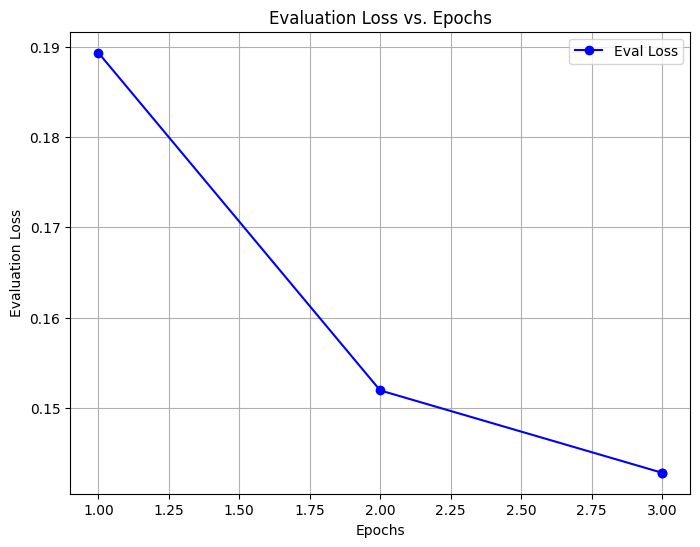

In [14]:
import matplotlib.pyplot as plt

def plot_eval_loss(trainer):
    logs = trainer.state.log_history
    eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]
    epochs = [log['epoch'] for log in logs if 'eval_loss' in log]
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, eval_losses, marker='o', linestyle='-', color='b', label='Eval Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Evaluation Loss')
    plt.title('Evaluation Loss vs. Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_eval_loss(trainer)

In [15]:
# trainer.save_model("./model_saved")
# roberta.tokenizer.save_pretrained("./model_saved")
# print("Model Saved to ./model_saved directory !!!")